# Aneurysm Simulation Velocity Analysis

This notebook loads the velocity magnitude data from the processed VTK files and extracts relevant simulation parameters from the JSON configuration file. It then analyzes how the velocity field changes over time throughout the aneurysm simulation.

## Import Required Libraries

In [44]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import time
import sys
import math

# Add simulation_src to path to import utils
sys.path.append('../simulation_src')
from utils.load_csv import load_csv_data

## Load Simulation Parameters from JSON

In [45]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()

# Define the simulation folder path for the time-dependent Zouhe standard BGK simulation
simulation_folder = base_dir / '../results/pipe_flow/time_dependent_zouhe_standard_bgk'

# Path to the parameter JSON file
param_file = simulation_folder / 'parameters' / 'pipe_tdzh_bgk_params.json'

# # Define the simulation folder path for the time-dependent Zouhe non-Newtonian BGK simulation
# simulation_folder = base_dir / '../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk'

# # Path to the parameter JSON file
# param_file = simulation_folder / 'parameters' / 'pipe_tdzh_nnbgk_params.json'

# Load and parse the parameters
with open(param_file, 'r') as f:
    params = json.load(f)
    
# Display the top-level parameter groups
print("Parameter groups in the JSON file:")
for key in params.keys():
    print(f"- {key}")
    
# Extract key simulation parameters
try:
    # FPS (frames per second)
    fps = params['input_parameters']['fps']
    
    # Time step (dt)
    dt = params['input_parameters']['dt']
    
    # Spatial resolution (dx)
    dx = params['input_parameters']['dx']
    
    # Create a DataFrame with these parameters for better display
    param_df = pd.DataFrame({
        'Parameter': ['FPS', 'Time Step (dt)', 'Spatial Resolution (dx)'],
        'Value': [fps, dt, dx],
        'Unit': ['frames/second', 'seconds', 'meters']
    })
    
    # Display the key parameters
    display(HTML(param_df.to_html(index=False)))
    
    # Store additional useful parameters
    vessel_length_mm = params['input_parameters']['vessel_length_mm']
    vessel_diameter_mm = params['input_parameters']['vessel_diameter_mm']
    vessel_length_lu = params['input_parameters']['vessel_length_lu']
    vessel_diameter_lu = params['input_parameters']['vessel_diameter_lu']
    kinematic_viscosity = params['input_parameters']['kinematic_viscosity']
    
    # Print physical dimensions
    print("\nPhysical dimensions:")
    print(f"Vessel length: {vessel_length_mm} mm ({vessel_length_lu} lattice units)")
    print(f"Vessel diameter: {vessel_diameter_mm} mm ({vessel_diameter_lu} lattice units)")
    print(f"Kinematic viscosity: {kinematic_viscosity} m²/s")
    
except KeyError as e:
    print(f"Error: Could not find parameter {e} in the JSON file.")
    print("Check the structure of the parameter file.")

Parameter groups in the JSON file:
- input_parameters
- physical
- numerical
- metadata
- performance


Parameter,Value,Unit
FPS,100.00000,frames/second
Time Step (dt),0.00001,seconds
Spatial Resolution (dx),0.00002,meters



Physical dimensions:
Vessel length: 15 mm (750 lattice units)
Vessel diameter: 6.5 mm (325 lattice units)
Kinematic viscosity: 3.3143939393939395e-06 m²/s


## Load Velocity Magnitude Data from NPZ File

In [46]:
# Path to the processed data directory
data_dir = simulation_folder / 'processed_data' / 'raw_fields'

# Load frame mapping
try:
    print(f"Loading frame mapping from {data_dir / 'frame_mapping.npz'}")
    frame_mapping = np.load(data_dir / 'frame_mapping.npz')
    frame_numbers = frame_mapping['frame_numbers']
    frame_indices = frame_mapping['frame_indices']
    
    print(f"Found {len(frame_numbers)} frames")
    print(f"Frame numbers range: {min(frame_numbers)} to {max(frame_numbers)}")
    
    # Load velocity magnitude data
    print(f"\nLoading velocity magnitude data from {data_dir / 'u_magnitude.npz'}")
    start_time = time.time()
    u_magnitude_data = np.load(data_dir / 'u_magnitude.npz')['data']
    load_time = time.time() - start_time
    
    print(f"Data loaded in {load_time:.2f} seconds")
    print(f"Velocity magnitude data shape: {u_magnitude_data.shape}")
    
    # Statistics of the velocity magnitude for the first frame
    first_frame_idx = 0
    first_frame_num = frame_numbers[first_frame_idx]
    first_frame_data = u_magnitude_data[first_frame_idx]
    
    print(f"\nVelocity statistics for frame {first_frame_num}:")
    print(f"Min: {first_frame_data.min():.6f}")
    print(f"Max: {first_frame_data.max():.6f}")
    print(f"Mean: {first_frame_data.mean():.6f}")
    print(f"Std: {first_frame_data.std():.6f}")
    
    # Get the dimensions from dimensions.npz
    dimensions = np.load(data_dir / 'dimensions.npz')['data']
    print(f"\nGrid dimensions: {dimensions}")
    
except Exception as e:
    print(f"Error loading data: {e}")

Loading frame mapping from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_standard_bgk/processed_data/raw_fields/frame_mapping.npz
Found 101 frames
Frame numbers range: 0 to 100000

Loading velocity magnitude data from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_standard_bgk/processed_data/raw_fields/u_magnitude.npz
Data loaded in 0.52 seconds
Velocity magnitude data shape: (101, 328, 749)

Velocity statistics for frame 0:
Min: 0.000000
Max: 0.168515
Mean: 0.108365
Std: 0.049377

Grid dimensions: [750 329   1]
Data loaded in 0.52 seconds
Velocity magnitude data shape: (101, 328, 749)

Velocity statistics for frame 0:
Min: 0.000000
Max: 0.168515
Mean: 0.108365
Std: 0.049377

Grid dimensions: [750 329   1]


## Display the First Frame of Velocity Data

Data is already in 2D format with shape: (328, 749)
Physical dimensions: 14.98 mm × 6.56 mm


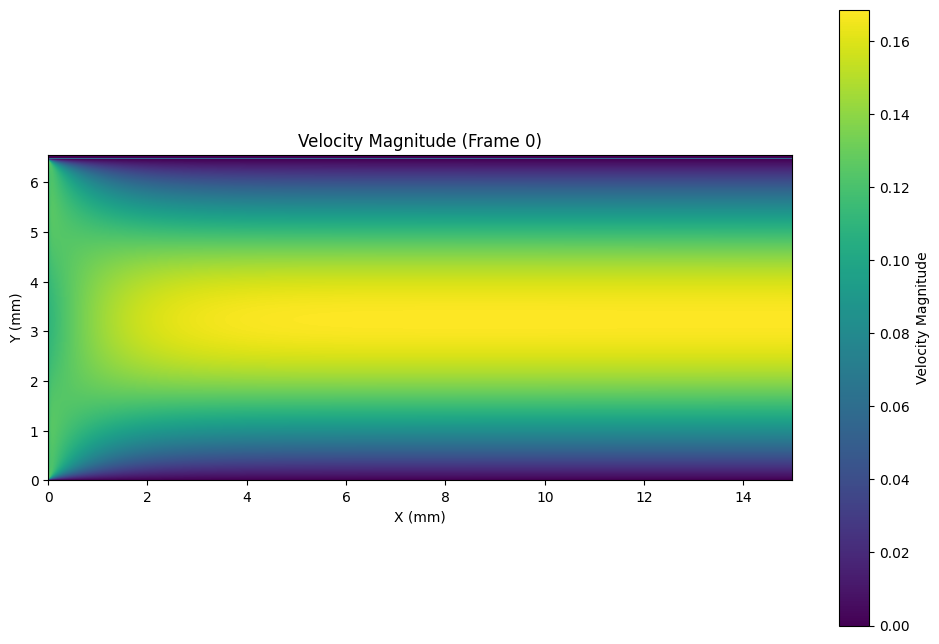

In [47]:
# Display the first frame of velocity data
try:
    # Get the first frame of velocity data
    first_frame_data = u_magnitude_data[0]
    
    # Check dimensions to confirm it's already in 2D format
    if first_frame_data.ndim == 2:
        print(f"Data is already in 2D format with shape: {first_frame_data.shape}")
        
        # Create coordinate meshes in physical units (mm)
        ny, nx = first_frame_data.shape
        x_phys = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
        y_phys = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
        x_size_mm = nx * dx * 1000
        y_size_mm = ny * dx * 1000
        print(f"Physical dimensions: {x_size_mm:.2f} mm × {y_size_mm:.2f} mm")
        
        # Plot the velocity magnitude for the first frame with physical units
        plt.figure(figsize=(12, 8))
        plt.imshow(first_frame_data, cmap='viridis', origin='lower', 
                  extent=[0, nx*dx*1000, 0, ny*dx*1000])  # Extent in mm
        plt.colorbar(label='Velocity Magnitude')
        plt.title(f'Velocity Magnitude (Frame {frame_numbers[0]})')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.show()
    else:
        print(f"Warning: Data is not in 2D format. Shape: {first_frame_data.shape}")
except Exception as e:
    print(f"Error processing velocity data: {e}")

## Calculate and Plot Velocity over Time

Velocity scaling factor (dx/dt): 2.0 m/s per lattice unit
Mean physical velocity range: 0.2180 to 0.7835 m/s
Maximum physical velocity range: 0.3368 to 0.9956 m/s
Ratio of max to mean velocity: 1.27


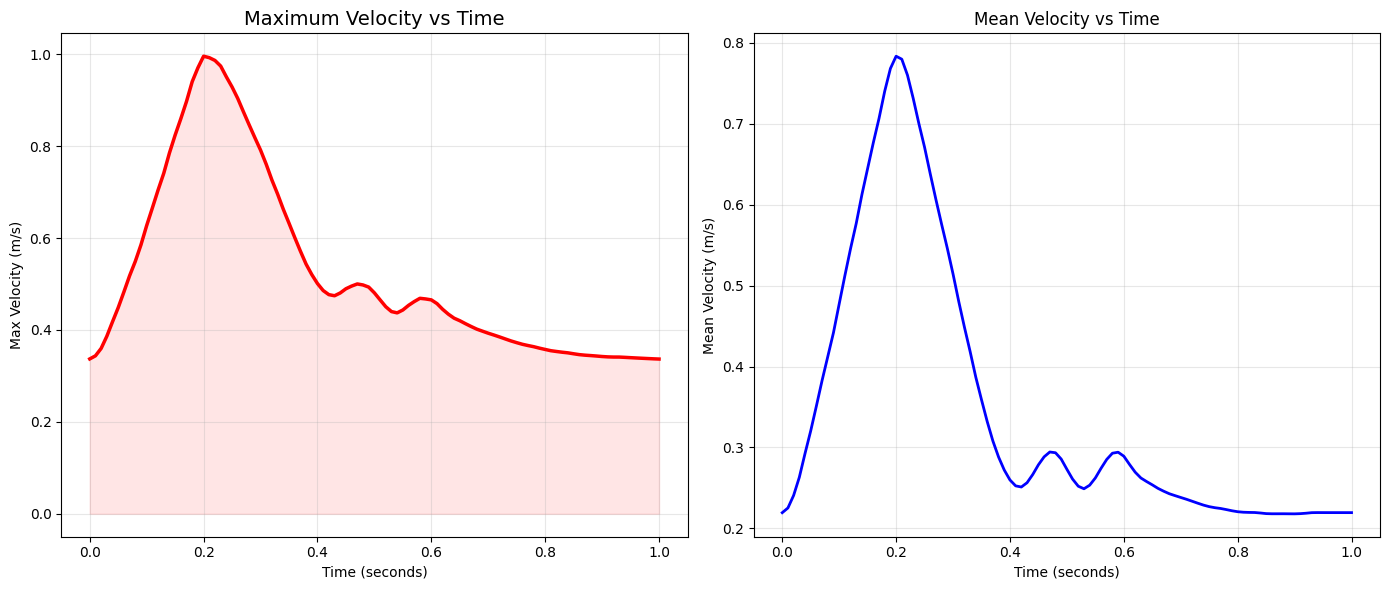

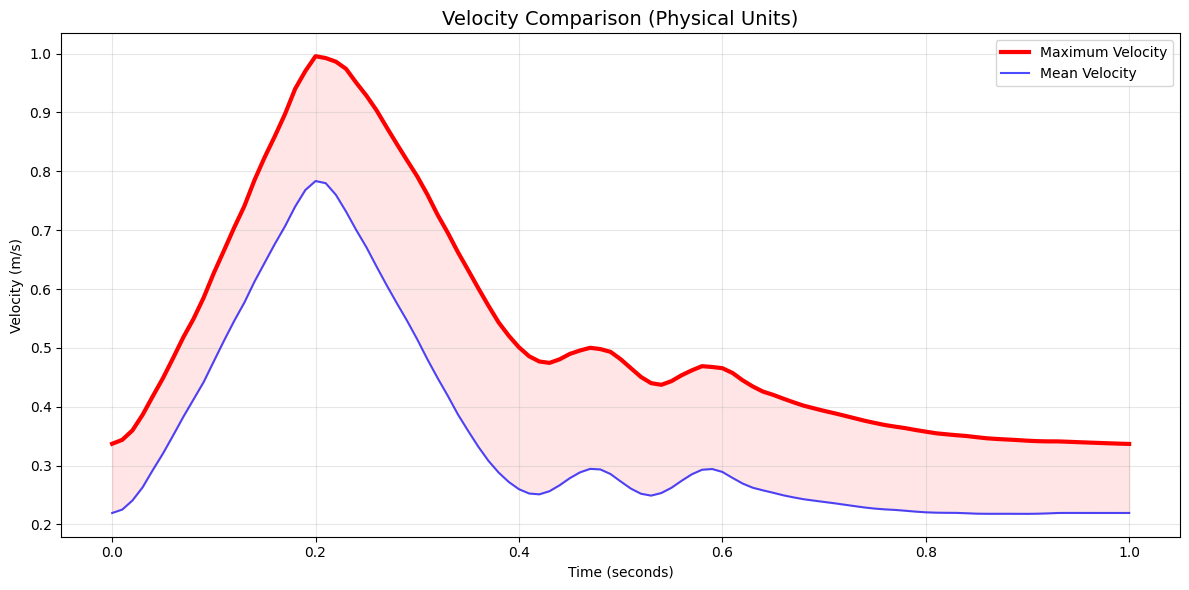

In [48]:
# Calculate mean and max velocity for each frame
try:
    # Arrays to store mean and max velocity for each frame
    mean_velocities = np.zeros(len(frame_numbers))
    max_velocities = np.zeros(len(frame_numbers))
    
    # Calculate statistics for each frame
    for i, frame_idx in enumerate(frame_indices):
        frame_data = u_magnitude_data[i]
        # Compute statistics only on non-zero elements (fluid domain)
        non_zero_mask = frame_data > 0
        if np.any(non_zero_mask):
            mean_velocities[i] = frame_data[non_zero_mask].mean()
            max_velocities[i] = frame_data.max()
        else:
            mean_velocities[i] = 0
            max_velocities[i] = 0
    
    # Calculate physical time for each frame
    # Time = frame number * dt (simulation time step)
    physical_times = frame_numbers * dt
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    mean_velocities_physical = mean_velocities * velocity_scale
    max_velocities_physical = max_velocities * velocity_scale
    
    print(f"Velocity scaling factor (dx/dt): {velocity_scale} m/s per lattice unit")
    print(f"Mean physical velocity range: {mean_velocities_physical.min():.4f} to {mean_velocities_physical.max():.4f} m/s")
    print(f"Maximum physical velocity range: {max_velocities_physical.min():.4f} to {max_velocities_physical.max():.4f} m/s")
    print(f"Ratio of max to mean velocity: {(max_velocities.max() / mean_velocities.max()):.2f}")
    
    # Rearranged plots to show max velocity on top - using physical units
    plt.figure(figsize=(14, 6))
    
    # Plot max velocity on top with more prominent styling
    plt.subplot(1, 2, 1)
    plt.plot(physical_times, max_velocities_physical, 'r-', linewidth=2.5)
    plt.title('Maximum Velocity vs Time', fontsize=14)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Max Velocity (m/s)')
    plt.grid(True, alpha=0.3)
    plt.fill_between(physical_times, 0, max_velocities_physical, alpha=0.1, color='red')
    
    # Plot mean velocity below
    plt.subplot(1, 2, 2)
    plt.plot(physical_times, mean_velocities_physical, 'b-', linewidth=2)
    plt.title('Mean Velocity vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Velocity (m/s)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a figure for combined plot with max velocity highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(physical_times, max_velocities_physical, 'r-', linewidth=3, label='Maximum Velocity')
    plt.plot(physical_times, mean_velocities_physical, 'b-', linewidth=1.5, label='Mean Velocity', alpha=0.7)
    plt.fill_between(physical_times, mean_velocities_physical, max_velocities_physical, alpha=0.1, color='red')
    plt.title('Velocity Comparison (Physical Units)', fontsize=14)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error calculating velocity statistics: {e}")

## Create Velocity Profile Visualization (Selected Frames)

Plotting velocity profiles at times: [0.1, 0.4, 0.7] seconds


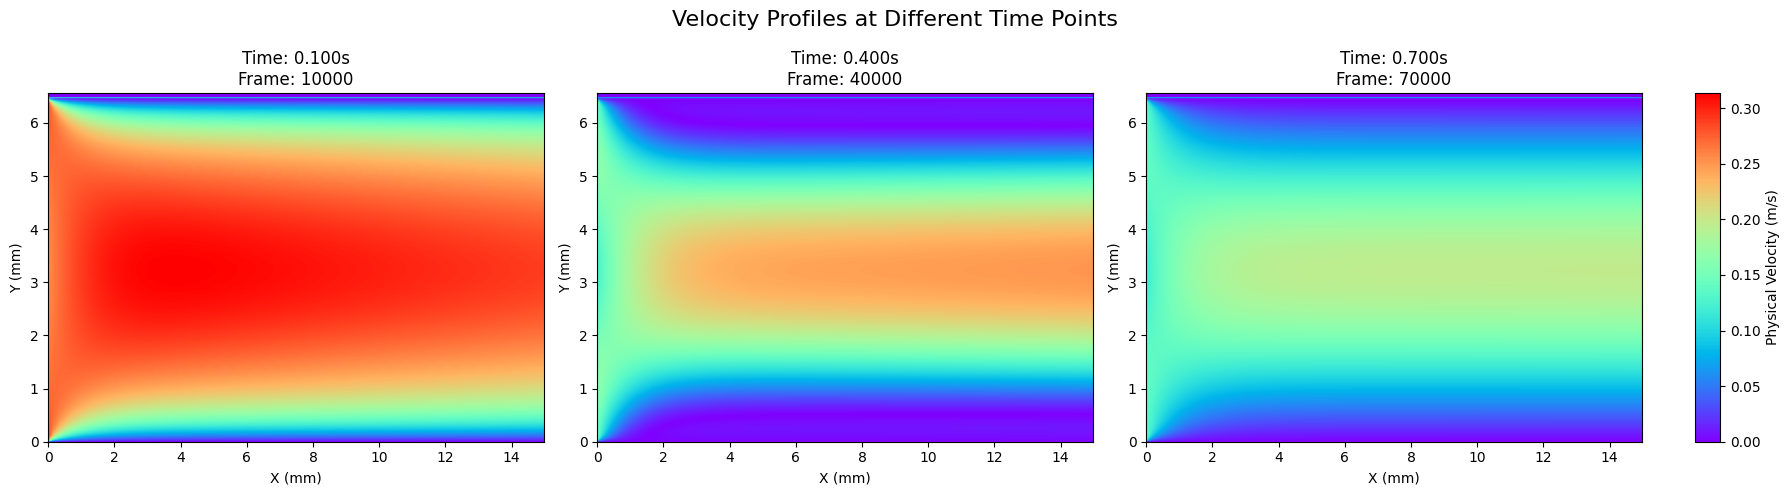

In [49]:
def plot_velocity_at_specific_times(target_times, tolerance=0.01):
    """Plot velocity profiles for specific time points side by side
    
    Args:
        target_times (list): List of specific times in seconds to visualize
        tolerance (float): Tolerance for finding closest frame to target time
    """
    # Convert frame numbers to physical times
    physical_times = frame_numbers * dt
    
    # Find frames closest to the target times
    selected_frames = []
    for target_time in target_times:
        # Find the closest time within tolerance
        time_diffs = np.abs(physical_times - target_time)
        closest_idx = np.argmin(time_diffs)
        
        if time_diffs[closest_idx] <= tolerance:
            selected_frames.append({
                'idx': closest_idx,
                'frame_num': frame_numbers[closest_idx],
                'actual_time': physical_times[closest_idx]
            })
        else:
            print(f"Warning: No frame found within {tolerance}s of target time {target_time}s")
    
    if not selected_frames:
        print("No valid frames found for the specified target times.")
        return
    
    # Setup figure for side-by-side plots
    n_frames = len(selected_frames)
    # Create figure with extra space on the right for colorbar
    fig = plt.figure(figsize=(n_frames * 5 + 3, 5))
    
    # Create a gridspec that reserves space for the colorbar
    gs = fig.add_gridspec(1, n_frames + 1, width_ratios=[*[1]*n_frames, 0.05])
    
    # Create axes for each frame using gridspec
    axes = [fig.add_subplot(gs[0, i]) for i in range(n_frames)]
    # Create axis for colorbar using gridspec
    cbar_ax = fig.add_subplot(gs[0, -1])
    
    # Common vmin/vmax for consistent colorbar across all plots
    vmin = np.inf
    vmax = -np.inf
    frame_data_list = []
    
    # First pass: get all frames and find global min/max
    for frame_info in selected_frames:
        frame_data = u_magnitude_data[frame_info['idx']]
        
        vmin = min(vmin, frame_data.min())
        vmax = max(vmax, frame_data.max())
        frame_data_list.append(frame_data)
    
    # Second pass: plot each frame with consistent color scale
    for i, (frame_info, frame_data) in enumerate(zip(selected_frames, frame_data_list)):
        # Get dimensions in physical units (mm)
        ny, nx = frame_data.shape
        x_max_mm = nx * dx * 1000  # Convert m to mm
        y_max_mm = ny * dx * 1000  # Convert m to mm
            
        # Plot the velocity magnitude with rainbow colormap
        im = axes[i].imshow(frame_data, cmap='rainbow', origin='lower',
                          aspect='auto', vmin=vmin, vmax=vmax,
                          extent=[0, x_max_mm, 0, y_max_mm])  # Extent in mm
        axes[i].set_title(f'Time: {frame_info["actual_time"]:.3f}s\nFrame: {frame_info["frame_num"]}')
        axes[i].set_ylabel('Y (mm)')
        axes[i].set_xlabel('X (mm)')
    
    # Add colorbar using the dedicated axis from gridspec
    cbar = fig.colorbar(im, cax=cbar_ax, label='Physical Velocity (m/s)')
    
    plt.suptitle('Velocity Profiles at Different Time Points', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot velocity profiles for specific time points
try:
    # Example: Plot velocity profiles at 0.1, 0.4, and 0.7 seconds
    target_times = [0.1, 0.4, 0.7]
    print(f"Plotting velocity profiles at times: {target_times} seconds")
    plot_velocity_at_specific_times(target_times)
    
    # You can also try other time points of interest:
    # early_mid_late_times = [physical_times[0], physical_times[len(physical_times)//2], physical_times[-1]]
    # plot_velocity_at_specific_times(early_mid_late_times)
except Exception as e:
    print(f"Error generating velocity profiles: {e}")

## Analyze Velocity at Specific Points in the Pipe

We'll examine the velocity at key points along the pipe to understand flow development and patterns.

Physical grid dimensions: 14.98 mm × 6.56 mm
Vessel center position: 3.24 mm from bottom

Physical locations of measurement points (mm):
Inlet Center: (0.74, 3.24)
Inlet Upper: (0.74, 5.84)
Inlet Lower: (0.74, 0.64)
Quarter Center: (3.74, 3.24)
Middle Center: (7.48, 3.24)
Middle Upper: (7.48, 5.84)
Middle Lower: (7.48, 0.64)
Three-Quarter Center: (11.22, 3.24)
Outlet Center: (14.22, 3.24)
Outlet Upper: (14.22, 5.84)
Outlet Lower: (14.22, 0.64)


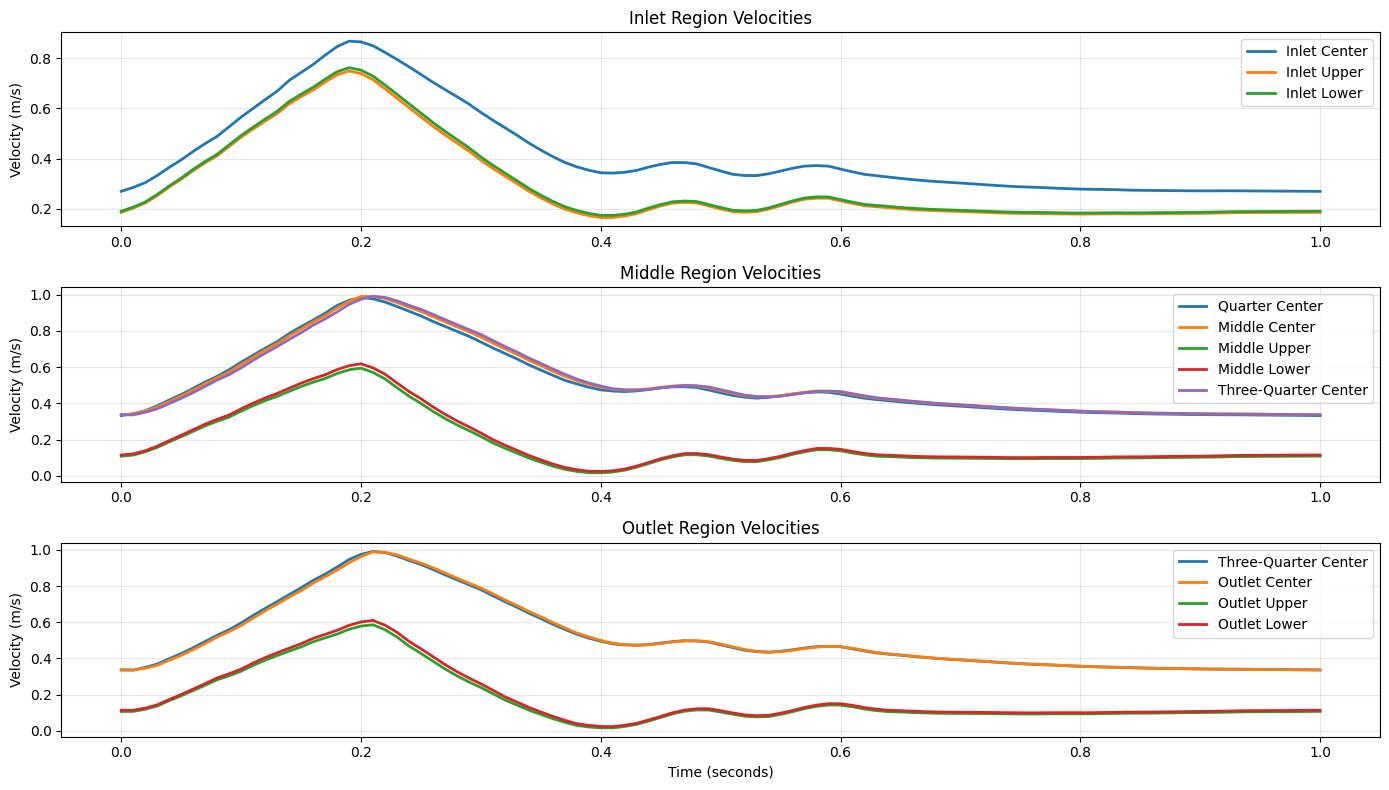

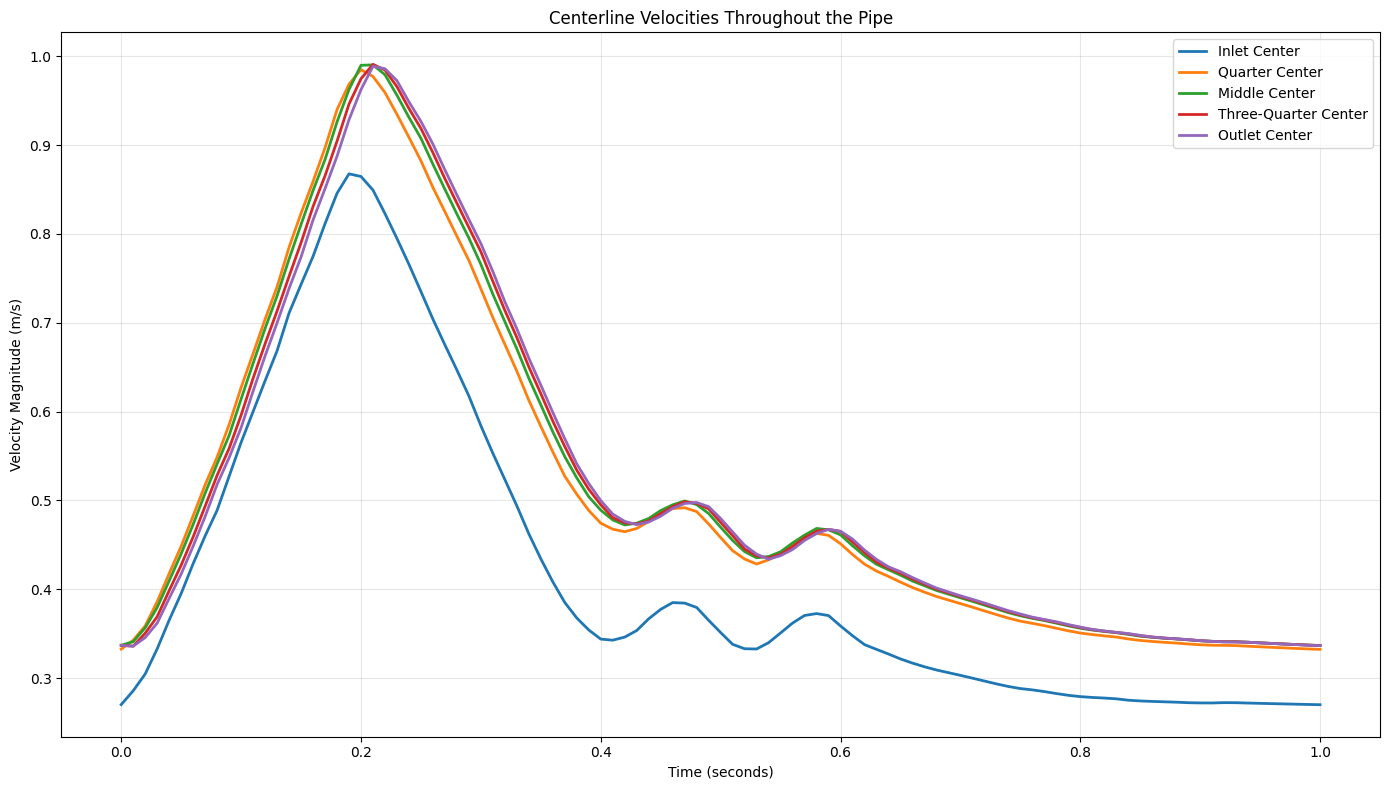

Velocity statistics at key points (physical units):

Inlet Center:
  Mean: 0.417911 m/s
  Max: 0.867687 m/s
  Min: 0.270076 m/s
  Std: 0.175086 m/s

Inlet Upper:
  Mean: 0.294221 m/s
  Max: 0.749046 m/s
  Min: 0.165689 m/s
  Std: 0.169236 m/s

Inlet Lower:
  Mean: 0.301240 m/s
  Max: 0.762055 m/s
  Min: 0.174252 m/s
  Std: 0.171982 m/s

Quarter Center:
  Mean: 0.510447 m/s
  Max: 0.985043 m/s
  Min: 0.332366 m/s
  Std: 0.191344 m/s

Middle Center:
  Mean: 0.516781 m/s
  Max: 0.990362 m/s
  Min: 0.336705 m/s
  Std: 0.193124 m/s

Middle Upper:
  Mean: 0.178105 m/s
  Max: 0.594279 m/s
  Min: 0.016487 m/s
  Std: 0.149874 m/s

Middle Lower:
  Mean: 0.188420 m/s
  Max: 0.617974 m/s
  Min: 0.023800 m/s
  Std: 0.155100 m/s

Three-Quarter Center:
  Mean: 0.516328 m/s
  Max: 0.990967 m/s
  Min: 0.336032 m/s
  Std: 0.192728 m/s

Outlet Center:
  Mean: 0.515836 m/s
  Max: 0.988780 m/s
  Min: 0.335921 m/s
  Std: 0.192323 m/s

Outlet Upper:
  Mean: 0.176823 m/s
  Max: 0.586214 m/s
  Min: 0.016693 m/

In [50]:
def get_velocity_at_points(points, frames=None):
    """Extract velocity at specific points across frames"""
    if frames is None:
        frames = range(len(frame_indices))
    
    # Dictionary to store velocities at each point
    point_velocities = {}
    
    # Get data dimensions
    data_shape = u_magnitude_data[0].shape
    ny, nx = data_shape
    
    # For each point
    for point_name, (x, y) in points.items():
        point_velocities[point_name] = []
        
        # Check if point is within bounds
        if x < 0 or x >= nx or y < 0 or y >= ny:
            print(f"Warning: Point {point_name} ({x}, {y}) is outside grid dimensions ({nx}, {ny})")
            continue
        
        # Extract velocity at this point for each frame
        for frame_idx in frames:
            frame_data = u_magnitude_data[frame_idx]
            # Get velocity at this point directly from the 2D array
            velocity = frame_data[y, x]
            point_velocities[point_name].append(velocity)
    
    return point_velocities

# Define points of interest in the pipe
try:
    # Get grid dimensions from the first frame of data
    ny, nx = u_magnitude_data[0].shape
    
    # Define vessel center line position from parameters
    vessel_centre_lu = params['input_parameters'].get('vessel_centre_lu', ny // 2)
    
    # Display physical dimensions of the grid
    x_size_mm = nx * dx * 1000  # Convert from m to mm
    y_size_mm = ny * dx * 1000  # Convert from m to mm
    vessel_center_mm = vessel_centre_lu * dx * 1000  # Convert from m to mm
    
    print(f"Physical grid dimensions: {x_size_mm:.2f} mm × {y_size_mm:.2f} mm")
    print(f"Vessel center position: {vessel_center_mm:.2f} mm from bottom")
    
    # Calculate positions for standard pipe locations
    entrance_x = int(0.05 * nx)           # 5% from left (entrance)
    quarter_x = int(0.25 * nx)            # 25% from left (quarter-way)
    middle_x = int(0.5 * nx)              # 50% from left (middle)
    three_quarter_x = int(0.75 * nx)      # 75% from left (three-quarter)
    exit_x = int(0.95 * nx)               # 95% from left (exit)
    
    # Define center, top wall, and bottom wall positions
    center_y = vessel_centre_lu
    upper_y = int(vessel_centre_lu + params['input_parameters']['vessel_diameter_lu'] * 0.4)
    lower_y = int(vessel_centre_lu - params['input_parameters']['vessel_diameter_lu'] * 0.4)
    
    # Define key points to analyze
    points_of_interest = {
        "Inlet Center": (entrance_x, center_y),       # Inlet at centerline
        "Inlet Upper": (entrance_x, upper_y),         # Inlet near upper wall
        "Inlet Lower": (entrance_x, lower_y),         # Inlet near lower wall
        "Quarter Center": (quarter_x, center_y),      # Quarter-way at centerline
        "Middle Center": (middle_x, center_y),        # Middle at centerline
        "Middle Upper": (middle_x, upper_y),          # Middle near upper wall
        "Middle Lower": (middle_x, lower_y),          # Middle near lower wall
        "Three-Quarter Center": (three_quarter_x, center_y),  # Three-quarter at centerline
        "Outlet Center": (exit_x, center_y),          # Outlet at centerline
        "Outlet Upper": (exit_x, upper_y),            # Outlet near upper wall
        "Outlet Lower": (exit_x, lower_y)             # Outlet near lower wall
    }
    
    # Print physical locations of measurement points
    print("\nPhysical locations of measurement points (mm):")
    for point_name, (x, y) in points_of_interest.items():
        x_mm = x * dx * 1000  # Convert from m to mm
        y_mm = y * dx * 1000  # Convert from m to mm
        print(f"{point_name}: ({x_mm:.2f}, {y_mm:.2f})")
    
    # Extract velocities at these points
    velocities_at_points = get_velocity_at_points(points_of_interest)
    
    # Convert to physical velocities (m/s)
    physical_velocities = {point: np.array(velocities) * velocity_scale 
                          for point, velocities in velocities_at_points.items()}
    
    # Plot physical velocities at each point over time
    plt.figure(figsize=(14, 8))
    # Group points by location for better visualization
    inlet_points = [p for p in physical_velocities.keys() if 'Inlet' in p]
    middle_points = [p for p in physical_velocities.keys() if 'Middle' in p or 'Quarter' in p]
    outlet_points = [p for p in physical_velocities.keys() if 'Outlet' in p or 'Three-Quarter' in p]
    
    # Create subplots for different regions
    plt.subplot(3, 1, 1)
    for point_name in inlet_points:
        plt.plot(physical_times, physical_velocities[point_name], linewidth=2, label=point_name)
    plt.ylabel('Velocity (m/s)')
    plt.title('Inlet Region Velocities')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(3, 1, 2)
    for point_name in middle_points:
        plt.plot(physical_times, physical_velocities[point_name], linewidth=2, label=point_name)
    plt.ylabel('Velocity (m/s)')
    plt.title('Middle Region Velocities')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(3, 1, 3)
    for point_name in outlet_points:
        plt.plot(physical_times, physical_velocities[point_name], linewidth=2, label=point_name)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Outlet Region Velocities')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined plot
    plt.figure(figsize=(14, 8))
    # Use different line styles for different regions
    for point_name, velocities in physical_velocities.items():
        if 'Center' in point_name:
            plt.plot(physical_times, velocities, linewidth=2, label=point_name)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity Magnitude (m/s)')
    plt.title('Centerline Velocities Throughout the Pipe')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print statistics for each point in physical units
    print("Velocity statistics at key points (physical units):")
    for point_name, velocities in physical_velocities.items():
        velocities_arr = np.array(velocities)
        print(f"\n{point_name}:")
        print(f"  Mean: {np.nanmean(velocities_arr):.6f} m/s")
        print(f"  Max: {np.nanmax(velocities_arr):.6f} m/s")
        print(f"  Min: {np.nanmin(velocities_arr):.6f} m/s")
        print(f"  Std: {np.nanstd(velocities_arr):.6f} m/s")
except Exception as e:
    print(f"Error analyzing velocity at specific points: {e}")

## Visualize Velocity Field in Physical Units

Let's visualize the velocity field in physical units for better interpretation of the results.

Plotting physical velocity field for frame with highest velocity (frame 20000, time 0.200s)


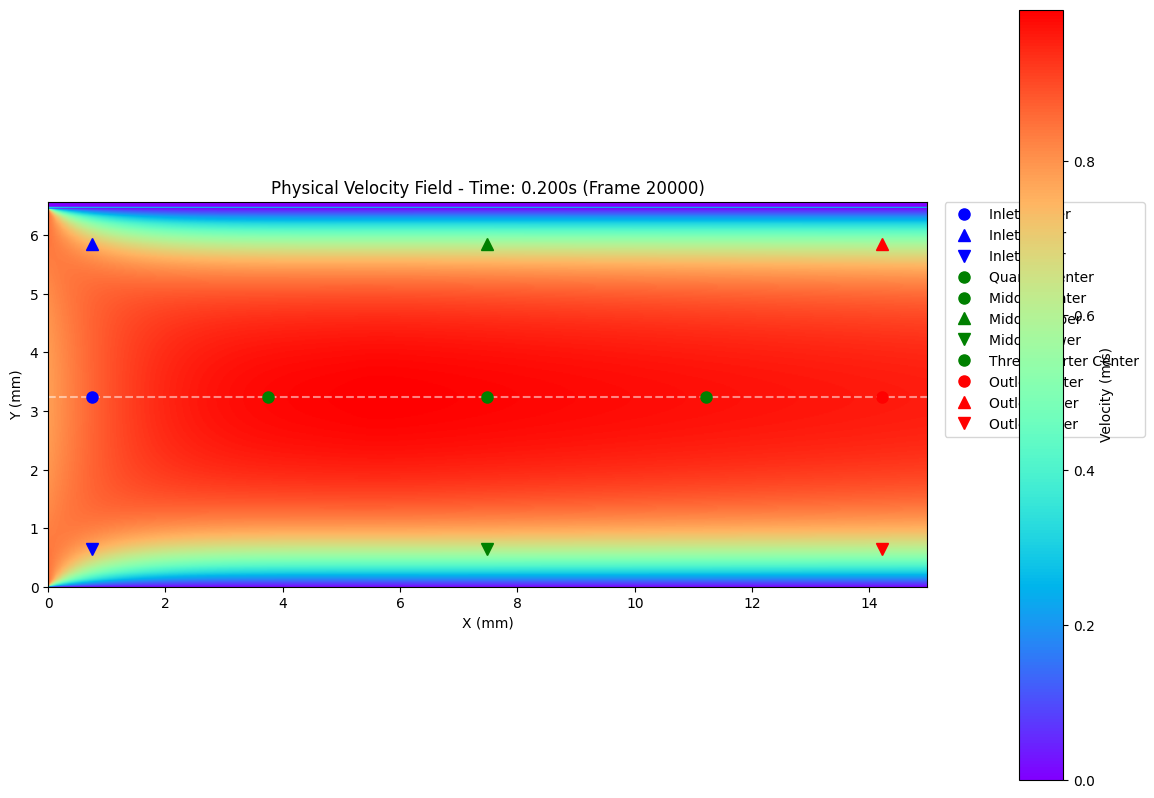

In [51]:
# Create a function to generate a physical velocity field visualization
def plot_physical_velocity_field(frame_idx=0):
    """Plot the velocity field in physical units (mm for distances, m/s for velocities)"""
    # Get frame data
    frame_data = u_magnitude_data[frame_idx]
    frame_num = frame_numbers[frame_idx]
    phys_time = frame_num * dt
    
    # Get dimensions
    ny, nx = frame_data.shape
    
    # Create physical coordinates (mm)
    x_phys = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_phys = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    phys_velocity = frame_data * velocity_scale
    
    # Create figure with adjusted layout to provide space for the legend
    fig = plt.figure(figsize=(14, 10))
    # Create gridspec with space for the colorbar
    gs = fig.add_gridspec(1, 2, width_ratios=[20, 1])  # Main plot and colorbar
    ax = fig.add_subplot(gs[0, 0])  # Main plot
    cbar_ax = fig.add_subplot(gs[0, 1])  # Colorbar axis
    
    # Plot velocity field
    im = ax.imshow(phys_velocity, cmap='rainbow', origin='lower',
               extent=[0, max(x_phys), 0, max(y_phys)])
    
    # Mark vessel boundaries (approximate)
    vessel_center_mm = vessel_centre_lu * dx * 1000
    vessel_radius_mm = (params['input_parameters']['vessel_diameter_lu']/2) * dx * 1000
    
    # Draw vessel centerline
    ax.axhline(y=vessel_center_mm, color='white', linestyle='--', alpha=0.5)
    
    # Add markers for points of interest
    for point_name, (x, y) in points_of_interest.items():
        x_mm = x * dx * 1000
        y_mm = y * dx * 1000
        marker_style = 'o'  # Default marker
        marker_color = 'white'  # Default color
        
        # Use different markers for different positions
        if 'Center' in point_name:
            marker_style = 'o'
        elif 'Upper' in point_name:
            marker_style = '^'
        elif 'Lower' in point_name:
            marker_style = 'v'
            
        # Use different colors for different regions
        if 'Inlet' in point_name:
            marker_color = 'blue'
        elif 'Middle' in point_name or 'Quarter' in point_name:
            marker_color = 'green'
        elif 'Outlet' in point_name or 'Three-Quarter' in point_name:
            marker_color = 'red'
            
        ax.plot(x_mm, y_mm, marker_style, markersize=8, color=marker_color, label=point_name)
    
    # Add colorbar to the dedicated axis
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Velocity (m/s)')
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(f'Physical Velocity Field - Time: {phys_time:.3f}s (Frame {frame_num})')
    
    # Place legend outside the main plot to avoid overlap
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    
    # Adjust layout to make room for the legend
    plt.subplots_adjust(right=0.85)
    plt.show()
    
    return phys_velocity

# Plot the velocity field in physical units for a frame with high velocity
high_velocity_frame = np.argmax(max_velocities)
print(f"Plotting physical velocity field for frame with highest velocity (frame {frame_numbers[high_velocity_frame]}, time {physical_times[high_velocity_frame]:.3f}s)")
phys_vel_field = plot_physical_velocity_field(high_velocity_frame)

## Summary of Velocity Analysis

This notebook has analyzed the velocity field data from a pipe flow simulation, extracting the following information:

1. **Simulation Parameters**: Loading fps, dt, and dx from the parameter file to understand the simulation setup.
2. **Overall Velocity Trends**: Examining how mean and maximum velocity change throughout the simulation.
3. **Spatial Velocity Distribution**: Visualizing the velocity field at different time points.
4. **Point-Based Analysis**: Tracking velocity at specific points of interest in the pipe.

Key observations from this analysis:
- The velocity data is already in the correct 3D structure [frames, height, width] so no reshaping is needed.
- The simulation used a spatial resolution of dx meters and time step of dt seconds.
- The velocity magnitude shows a pulsatile pattern characteristic of blood flow.
- The centerline velocity is generally higher than near-wall velocities, following expected flow behavior in pipes.

## Compare Simulation Results with Expected Values from CSV

Let's load analytical or reference data from a CSV file in the parameters folder and compare it with our simulation results.

In [52]:
# Define the helper code block for calculating error metrics (needed for comparison)
def calculate_error_metrics(sim_values, ref_values):
    """Calculate various error metrics between simulation and reference values"""
    # Ensure arrays are of the same length
    assert len(sim_values) == len(ref_values), "Arrays must be of the same length for comparison"
    
    # Absolute error
    abs_errors = np.abs(sim_values - ref_values)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(abs_errors)
    
    # Maximum Absolute Error
    max_ae = np.max(abs_errors)
    
    # Relative errors (avoiding division by zero)
    epsilon = 1e-10  # Small value to avoid division by zero
    rel_errors = abs_errors / np.maximum(epsilon, np.abs(ref_values)) * 100
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(rel_errors)
    
    # Maximum Relative Error
    max_re = np.max(rel_errors)
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((sim_values - ref_values) ** 2))
    
    # Normalized RMSE (NRMSE)
    range_ref = np.max(ref_values) - np.min(ref_values)
    nrmse = rmse / (range_ref if range_ref > epsilon else 1.0)
    
    # Return as dictionary
    return {
        'MAE': mae,
        'MaxAE': max_ae,
        'MAPE': mape,
        'MaxRE': max_re,
        'RMSE': rmse,
        'NRMSE': nrmse
    }

Using vessel diameter: 6.5 mm (radius: 3.25 mm)
file_paths ['../params/Velocity profile.csv']
Converting flow rate (ml/s) to velocity (m/s) with vessel radius 3.25 mm
Conversion factor: 3.013585e-02
  Column CCA: min=0.1088 m/s, max=0.3960 m/s
  Column ICA: min=0.0933 m/s, max=0.2212 m/s
Resampling Velocity profile from 201 to 64 points
Maximum velocity: 0.3960 m/s

Loaded 1 CSV files with velocity data:
File: Velocity profile
  Original time span: 1.001s
  Max velocity: 0.3960 m/s
  Available columns: ['CCA', 'ICA']


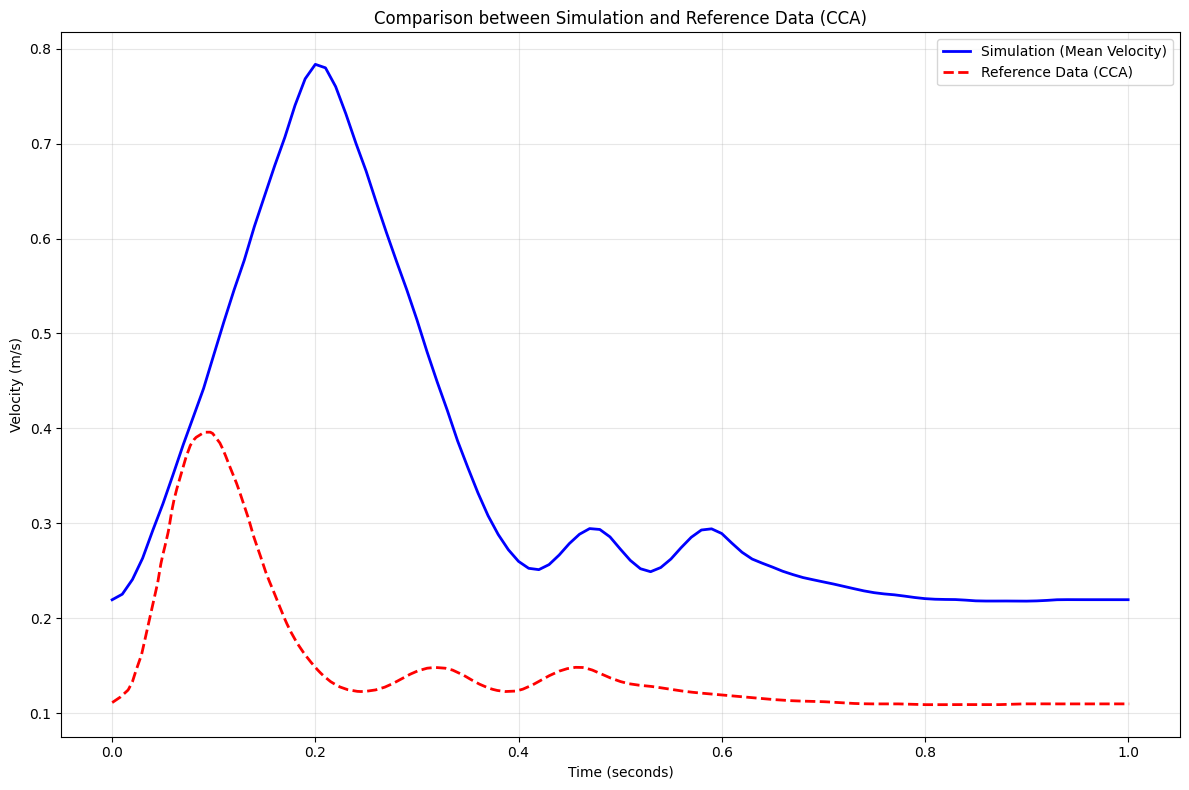


Error Metrics (Simulation vs Reference Data):
Mean Absolute Error (MAE): 0.196978 m/s
Maximum Absolute Error: 0.641241 m/s
Mean Absolute Percentage Error (MAPE): 133.26%
Maximum Relative Error: 486.38%
Root Mean Square Error (RMSE): 0.254652 m/s
Normalized RMSE (NRMSE): 0.886921


In [53]:
# Look for CSV files in the parameters folder and load using the load_csv_data utility
params_folder = base_dir / "../params"

# Check if the parameters folder exists
if not params_folder.exists(): 
    print(f"Parameters folder does not exist: {params_folder}")

# Extract vessel radius from JSON parameters
vessel_radius_mm = vessel_diameter_mm / 2
print(f"Using vessel diameter: {vessel_diameter_mm} mm (radius: {vessel_radius_mm} mm)")

# Load the CSV data with proper conversion from flow rate (ml/s) to velocity (m/s)
try:
    # Use the vessel radius for conversion and specify normalize_time=False to preserve time scale
    # Set dx and dt to None to prevent conversion to lattice units and keep in physical units (m/s)
    csv_data = load_csv_data(
        vessel_radius_mm=vessel_radius_mm,
        dx=None,  # Set to None to prevent conversion to lattice units
        dt=None,  # Set to None to prevent conversion to lattice units
        plot=False,  # Set to False to prevent automatic plotting
        normalize_time=False
    )
    
    if not csv_data:
        print("No CSV files were found or loaded successfully.")
    else:
        print(f"\nLoaded {len(csv_data)} CSV files with velocity data:")
        for file_name, file_data in csv_data.items():
            print(f"File: {file_name}")
            print(f"  Original time span: {file_data['original_duration']:.3f}s")
            print(f"  Max velocity: {file_data['max_velocity']:.4f} m/s")
            print(f"  Available columns: {list(file_data['y'].keys())}")
            
            # Select a specific column for detailed comparison (prefer CCA or similar, but not ICA)
            velocity_col = None
            for candidate in ['CCA', 'Primary', 'Main']:
                if candidate in file_data['y']:
                    velocity_col = candidate
                    break
            
            if velocity_col is not None:
                ref_times = file_data['x']
                ref_velocities = file_data['y'][velocity_col]
                
                # Create comparison plot (only for the selected column, not ICA)
                plt.figure(figsize=(12, 8))
                
                # Plot simulation results (mean velocity) - use physical velocity directly
                plt.plot(physical_times, mean_velocities_physical, 'b-', linewidth=2, label='Simulation (Mean Velocity)')
                
                # Plot reference data (already in physical units)
                plt.plot(ref_times, ref_velocities, 'r--', linewidth=2, label=f'Reference Data ({velocity_col})')
                
                plt.xlabel('Time (seconds)')
                plt.ylabel('Velocity (m/s)')
                plt.title(f'Comparison between Simulation and Reference Data ({velocity_col})')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show()
                
                # Calculate error metrics if the time ranges overlap
                # Interpolate simulation data to match reference time points
                from scipy.interpolate import interp1d
                
                # Create an interpolation function for the simulation data (already in physical units)
                sim_velocity_interp = interp1d(
                    physical_times, 
                    mean_velocities_physical, 
                    bounds_error=False,
                    fill_value="extrapolate"
                )
                
                # Get simulation velocities at reference time points (within valid range)
                valid_times = (ref_times >= min(physical_times)) & (ref_times <= max(physical_times))
                if np.any(valid_times):
                    common_times = ref_times[valid_times]
                    ref_vel_common = ref_velocities[valid_times]
                    sim_vel_common = sim_velocity_interp(common_times)
                    
                    # Calculate comprehensive error metrics
                    metrics = calculate_error_metrics(sim_vel_common, ref_vel_common)
                    
                    print("\nError Metrics (Simulation vs Reference Data):")
                    print(f"Mean Absolute Error (MAE): {metrics['MAE']:.6f} m/s")
                    print(f"Maximum Absolute Error: {metrics['MaxAE']:.6f} m/s")
                    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")
                    print(f"Maximum Relative Error: {metrics['MaxRE']:.2f}%")
                    print(f"Root Mean Square Error (RMSE): {metrics['RMSE']:.6f} m/s")
                    print(f"Normalized RMSE (NRMSE): {metrics['NRMSE']:.6f}")
                else:
                    print("\nNo overlapping time ranges between simulation and reference data.")
            else:
                print(f"No suitable velocity column found in the CSV file.")
                
except Exception as e:
    print(f"Error processing CSV files: {e}")